### Dimensionalidad

- Por dimensionalidad hacemmos referencia donde tenemos más atributos que casos en una base de datos. Debemos usar metodos para disminuir la dimensionalidad de los datos 

#### La maldición de la dimensionalidad
- Tecnicas de aprendizaje no supervizados: ausencia de info previa sobre los atributos y o vector objetivo, hablamos de dimensiones latentes como atributos existentes pero no medibles. Se caracterizan en dos grandes tecnicas:
    - Reducción de dimensionalidad: Objetivo es minimizar una gran cantidad de atributos en una serie de dimensiones sustancialmente menores
    - Clustening: agrupar los puntos en distintos conjuntos de datos dado reglas de similitud o diferencia
    
#### Maldición de dimensionalidad:
- Hasta ahora los algoritmos operan en un número finito de dimensiones. Si nosotros estamos trabajando con un problema de clasificación con 6 atirbutos, se dice que nuestro problema tiene 6 dimensiones. En la medida que aumenta el numero de dimensiones el desempeño del algoritmo empeora, por eso se dice maldicion de la dimensionalidad.
- El problema de la maldicion de la dimensionalidad es que la convergencia de cualquier estimador al parametro verdadero de una funcion definida en un espacio D dimensional es muy lento


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings

#especificaciones
warnings.filterwarnings(action = 'ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
import factor_analyzer as factor
import missingno as msgn

df = pd.read_csv('cep45.csv')

In [6]:
df.columns

Index(['corr', 'filtro', 'psu', 'region', 'p1_1', 'p1_2', 'p1_3', 'p2', 'p3',
       'p4',
       ...
       'de14_b', 'de14_c', 'de14_d', 'de14_e', 'de14_f', 'de15', 'de16',
       'de17', 'b5', 'pond'],
      dtype='object', length=188)

In [7]:
#filtamos todas las columnas que contenta p17
trust_df = df.filter(regex='p17_*')

In [9]:
#Observación al azar del dataframe filtrado 
trust_df.sample()


,p17_a,p17_b,p17_c,p17_d,p17_e,p17_f,p17_g,p17_h,p17_i,p17_j,p17_k,p17_l,p17_m,p17_n
166,3,2,3,4,3,3,3,4,2,3,3,3,3,3


In [11]:
trust_df = trust_df.rename(columns= {
    'p17_a': 'I.Catolica', 'p17_b': 'I.Evangelica', 
    'p17_c': 'FFAA', 'p17_d': 'Justicia',
    'p17_e': 'Prensa', 'p17_f': 'Television', 
    'p17_g':'Sindicatos', 'p17_h':'Carabineros',
    'p17_i': 'Gobierno', 'p17_j': 'PartidosPol', 
    'p17_k': 'Congreso', 'p17_l':'Empresas',
    'p17_m':'Universidades', 'p17_n':'Radio'})


#### analisis de dato perdidos

In [14]:
def fetch_missing(df, missing_vals):
    for colname, serie in df.iteritems():
        print(colname, serie.isin(missing_vals).value_counts('%')[1].round(2))
        
fetch_missing(trust_df, missing_vals=[8,9])

I.Catolica 0.03
I.Evangelica 0.07
FFAA 0.04
Justicia 0.04
Prensa 0.03
Television 0.02
Sindicatos 0.09
Carabineros 0.02
Gobierno 0.03
PartidosPol 0.03
Congreso 0.05
Empresas 0.04
Universidades 0.07
Radio 0.03


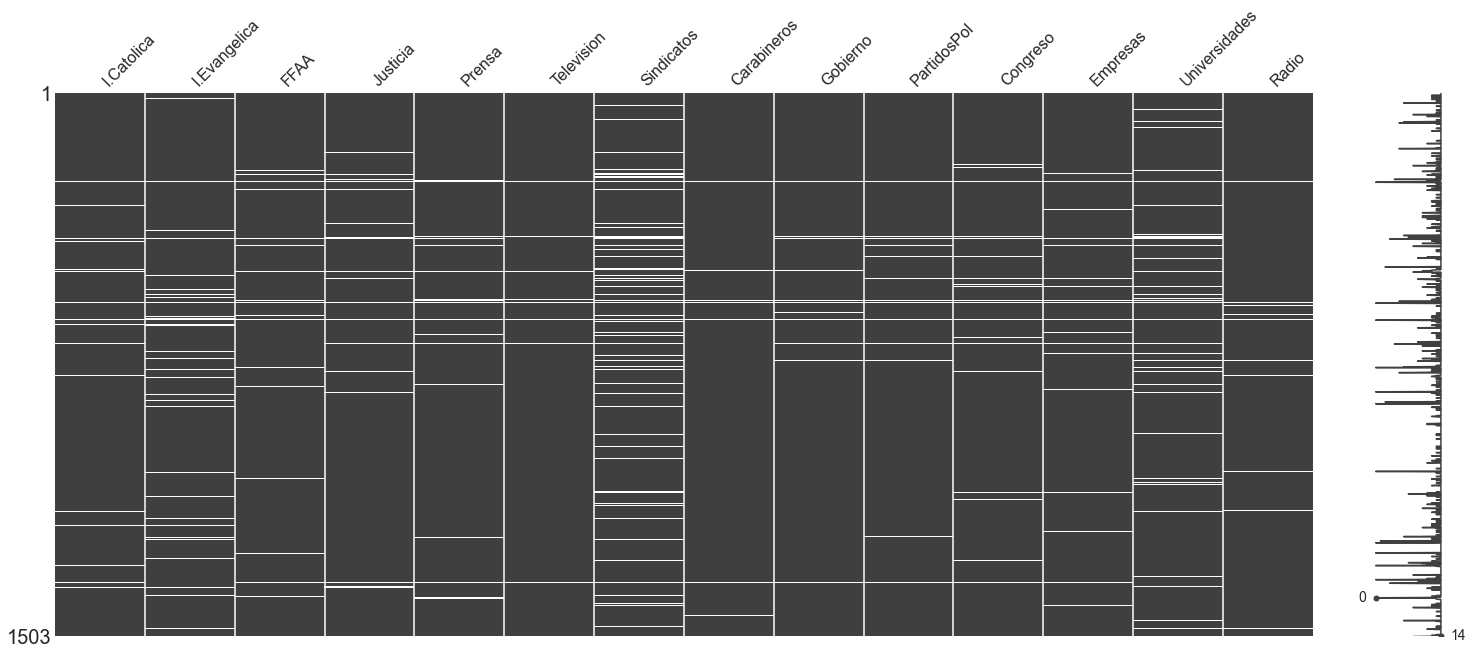

In [16]:
msgn.matrix(trust_df.replace([8,9], [np.nan, np.nan]))

#### Analisis de las medias

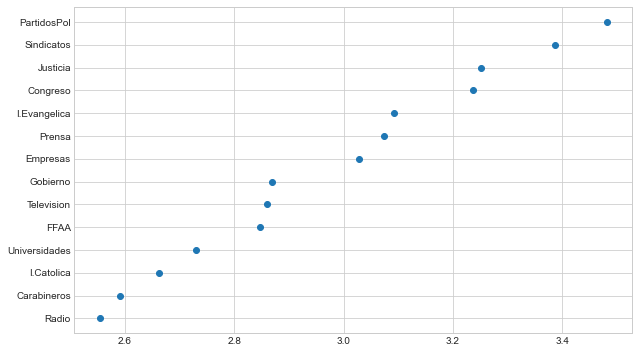

In [18]:
variable = []
mean = []
# para cada columna de la base, extraemos su nombre y sus valores
for colname, serie in trust_df.iteritems():
    # guardamos el nombre en variable
    variable.append(colname)
    # calculamos y procesamos la media
    mean.append(serie.mean())
    
tmp_df = pd.DataFrame({'var':variable, 'mean': mean}).sort_values(by=['mean'])
plt.plot(tmp_df['mean'], tmp_df['var'],'o')

## Supuesto de ideonidad factorial
### Prueba de espericidad de Barlett
- Queremos saber si nuestra matriz es idonea para realizar un análisis de factores debemos realizar una prueba de esferacidad de Barlett
- Con esta prueba buscamos ver si es una matriz de identidad, por ello realizamos una prueba de hipotesis:
    - Hipotesis nula: La matriz de correlaciones es una matriz de identidad
    - Hipótesis Alternativa: La matriz de correlaciones no es una matriz de identidad

In [50]:
import factor_analyzer as factor
#Usamo la función para hacer la prueba de Barlett
factor.calculate_bartlett_sphericity(trust_df)

(6644.835705911947, 0.0)

En la prueba de esferacidad encontramos lo siguiente:
- Primer número es estadistico de prueba -> chi cuadrado
- Segundo número, funciona como similar a la prueba de hipotesis, valores menores a 0.5 indica evidencia en contra de la hipotesis nula de que es una matriz de identidad
En este caso existe evidencia para rechazar la hipotesis nula podemos decir que existe por lo menos algún grado de covarianza entre los items

### Prueba Kaiser-Meyer-Olkin
- Posterior a la prueba de barlett debemos hacer la Kaise Mayer. 
- KMO busca resolver si es que las correlaciones parciales entre dos items son cercanas a cero

In [28]:
factor.calculate_kmo(trust_df)

(array([0.93853431, 0.92717654, 0.93176781, 0.95285454, 0.91971575,
        0.88552639, 0.93671982, 0.91120486, 0.93981619, 0.91291311,
        0.91928052, 0.94234885, 0.95178434, 0.93221226]),
 0.9274657194111268)

- Si puntaje >0.7 confirma que existe al menos un factor latente relevante 
- El ultimo factor es el global, si es >0.7 esxiste al menos un factor latente. Para valores bajo 0.7 se recomienda eliminarlos del df

## Estimando la cantidad de factores latentes
Posterior al analisis de la idoniedad de la matriz, debemos responder que tantos factores necesitamos
- Analizamos los eigenvalues de la decomposición de la matriz
- Las cargas no tienen identificación única:
    - Rotación Ortogonal: No permiten correlacionar de factores
    - Rotación Oblicua: Permite correlacionar factores

In [49]:
factorize = factor.FactorAnalyzer().fit(trust_df)
factorize.set_params(n_factors=7, method='varimax')
factor_screenplot = factorize.get_eigenvalues()[0]

plt.plot(factor_screenplot.index + 1, factor_screenplot.values, 'o-', color = 'tomato')
#print(eigen_values, vectors)

#factorize.analyze(data=trust_df, n_factors=2, method='varimax')

AttributeError: 'numpy.ndarray' object has no attribute 'index'